In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


device_type = 'cuda' if torch.cuda.is_available else 'cpu'

device = torch.device(device_type)
print(device_type)


cuda


# Problem 1

a) Instantiate a sequence to sequence transformer (self-attention) using a standard API (tensorflow, pytorch, etc). Verify with some examples that it is permutation equivariant.

b) Prove analytically using the defining equations of self-attention that the transformer architecture is permutation equivariant.

c) Repeat (b) for multi-headed attention.

# Problem 2

a) Train the MNIST VAE from class. Illustrate with some example scans across the 2d latent space how the digits morph from one into another.


Here we've built a VAE from scratch (I chose to do this so I could learn what was going on under the hood). First, let's instantiate the data.

In [2]:

# Import MNIST dataset

from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader


mnist_data = datasets.MNIST(root='data', train=True,
                            transform = T.Compose(
                                        [T.ToTensor(),
                                        T.Lambda(lambda x: x.view(-1))]
                                        ),
                            download=True)

# Parameters for training
batch_size = 100
batch_size_test = 100
num_epochs = 10


# Try using dataloader module to randomly provide datapts from dataset

size_mnist = 28*28

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.61MB/s]


Now we'll architect the VAE.

In [3]:
# Architecting the variational autoencoder

class VAE_MNIST(nn.Module):
    def __init__(self, latent_space_dim):
        super(VAE_MNIST, self).__init__()

        # define the encoder
        layer_one_size = 500
        layer_two_size = 200
        layer_three_size = 20

        self.fc1 = nn.Linear(size_mnist, layer_one_size)
        self.fc2 = nn.Linear(layer_one_size, layer_two_size)
        self.fc3 = nn.Linear(layer_two_size, layer_three_size)
        self.mean = nn.Linear(layer_three_size, latent_space_dim)
        self.std_dev = nn.Linear(layer_three_size, latent_space_dim)


        # define decoder layers

        self.dfc1 = nn.Linear(latent_space_dim, layer_three_size)
        self.dfc2 = nn.Linear(layer_three_size, layer_two_size)
        self.dfc3 = nn.Linear(layer_two_size, layer_one_size)
        self.img = nn.Linear(layer_one_size, size_mnist)

        # Bring the image down multiple layers into the latent dimensional space

    def encoder(self, x):


        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        h = self.fc3(h)
        return self.mean(h), self.std_dev(h)


    # Performs the reparameterization trick

    def sampling(self, mu, log_variance):
        std = torch.exp(0.5*log_variance)
        epsilon = torch.randn_like(std)
        return mu + std*epsilon # double check if this is allowed

    # Bring point in latent dimensional space to image space

    def decoder(self, x):
        h = F.leaky_relu(self.dfc1(x))
        h = F.leaky_relu(self.dfc2(h))
        h = F.leaky_relu(self.dfc3(h))

        return torch.sigmoid(self.img(h))

    # Forward step

    def forward(self, x):
        # encode in latent space
        mu, log_variance = self.encoder(x)
        # sample from the distribution
        z = self.sampling(mu, log_variance)
        # decode
        return self.decoder(z), mu, log_variance

    def loss(self, output, input, mu, log_variance):
        # Since the prior is just the normal dist. the KL divergence takes on the form
        KL = -1/2*torch.sum(1+log_variance-mu.pow(2)-log_variance.exp())
        # Binary cross-entropy is same as usual
        BCE = F.binary_cross_entropy(output, input, reduction='sum')
        return BCE+KL

In [4]:
from torch.utils.data import Subset

# Define autoencoder model

mnist_vae = VAE_MNIST(latent_space_dim=2)
mnist_vae_optim = torch.optim.Adam(mnist_vae.parameters())

# train the model


def vae_train(model, epoch_size, dataset, optimizer):
    model.train()
    dataloader = DataLoader(dataset=Subset(mnist_data, np.random.choice(len(mnist_data), 5000)), batch_size=100, shuffle=True)
    for epoch in range(epoch_size):
        for input, target in dataloader:
            optimizer.zero_grad()
            output, mu, log_variance = model(input)

            loss = model.loss(output, input, mu, log_variance)
            loss.backward()
            optimizer.step()

In [5]:
vae_train(mnist_vae, 20, mnist_data, mnist_vae_optim)

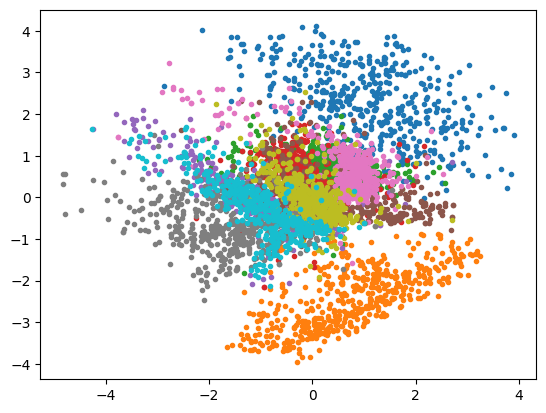

In [6]:
# Map out all of the different numbers in our latent space


# plot_dataloader = DataLoader(dataset=Subset(mnist_data, np.random.choice(len(mnist_data), 1000)), batch_size=1, shuffle=True)
# colors = plt.cm.tab10(np.linspace(0,1,10))


# xlist  = []
# ylist = []
# for input, target in plot_dataloader:
#     result, mu, log_variance = mnist_vae(input)
#     with torch.no_grad():
#         plt.scatter(mu.numpy()[0][0], mu.numpy()[0][1], color = colors[target])


# plt.show()


# Map out all of the different numbers in our latent space


colors = plt.cm.tab10(np.linspace(0,1,10))


empty = []
list_coords = [[[],[]] for _ in range(10)]

with torch.no_grad():
    for input, target in Subset(mnist_data, np.random.choice(len(mnist_data),5000)):
        result, mu, log_variance = mnist_vae(input)
        list_coords[target][0].append(mu[0])
        list_coords[target][1].append(mu[1])

    for target, element in enumerate(list_coords):
        plt.scatter(element[0], element[1], color = colors[target], marker = '.')
plt.show()


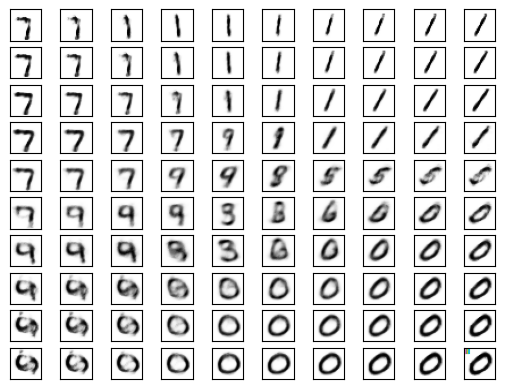

In [7]:
# Now attempt to generate a number from the graph

# new_image = new_image.reshape((28,28))
# with torch.no_grad():
#     plt.imshow(new_image.numpy(), cmap='Greys')

# grid


rows = 10
cols = 10

xlist = np.linspace(-4, 4, rows)
ylist = np.linspace(-4, 4, cols)

fig, axes = plt.subplots(rows, cols)

xpts, ypts = np.meshgrid(xlist, ylist)

plt.plot(xpts, ypts)


with torch.no_grad():
    for i, row in enumerate(xpts):
        for j, item in enumerate(xpts):
            new_img = mnist_vae.decoder(torch.tensor([xpts[i][j], ypts[i][j]], dtype=torch.float))
            new_img = new_img.reshape((28, 28))
            im = axes[i][j].imshow(new_img.numpy(), cmap = 'Greys')
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])



b) Train a vanilla autoencoder on MNIST and compare the latent space to the VAE.

In [8]:
# Compare to a standard autoencoder and see the results


class standard_autoencoder(nn.Module):
    def __init__(self, latent_space_dim):
        super(standard_autoencoder, self).__init__()

        # define the encoder
        layer_one_size = 100
        layer_two_size = 50
        layer_three_size = 20

        self.fc1 = nn.Linear(size_mnist, layer_one_size)
        self.fc2 = nn.Linear(layer_one_size, layer_two_size)
        self.fc3 = nn.Linear(layer_two_size, layer_three_size)
        self.mean = nn.Linear(layer_three_size, latent_space_dim)
        self.std_dev = nn.Linear(layer_three_size, latent_space_dim)


        # define decoder layers

        self.dfc1 = nn.Linear(latent_space_dim, layer_three_size)
        self.dfc2 = nn.Linear(layer_three_size, layer_two_size)
        self.dfc3 = nn.Linear(layer_two_size, layer_one_size)
        self.img = nn.Linear(layer_one_size, size_mnist)


        # Bring the image down multiple layers into the latent dimensional space

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.mean(h), self.std_dev(h)

    # Bring point in latent dimensional space to image space

    def decoder(self, x):
        h = F.relu(self.dfc1(x))
        h = F.relu(self.dfc2(h))
        h = F.relu(self.dfc3(h))

        return torch.sigmoid(self.img(h))

    # Forward step

    def forward(self, x):
        # encode in latent space
        mu, log_variance = self.encoder(x)
        # decode
        return self.decoder(mu), mu, log_variance

    def loss(self, output, input, mu, log_variance):
        # Just the binary cross-entropy loss
        BCE = F.binary_cross_entropy(output, input, reduction='sum')
        return BCE


In [9]:
# train this normal autoencoder

mnist_autoencoder = standard_autoencoder(latent_space_dim=2)
mnist_autoencoder_optimizer = torch.optim.Adam(mnist_autoencoder.parameters())

vae_train(model=mnist_autoencoder, epoch_size=20, dataset=mnist_data, optimizer=mnist_autoencoder_optimizer)

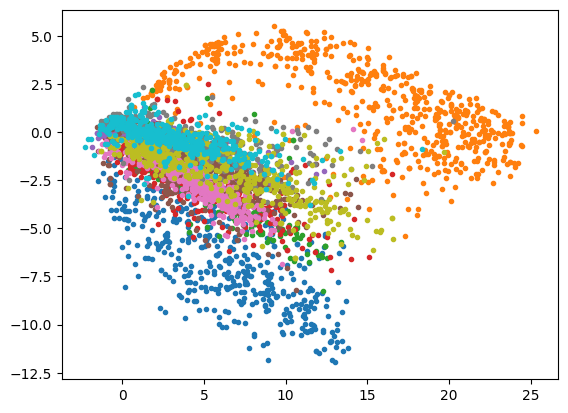

In [10]:


colors = plt.cm.tab10(np.linspace(0,1,10))

empty = []
list_coords = [[[],[]] for _ in range(10)]

with torch.no_grad():
    for input, target in Subset(mnist_data, np.random.choice(len(mnist_data),5000)):
        result, mu, log_variance = mnist_autoencoder(input)
        list_coords[target][0].append(mu[0])
        list_coords[target][1].append(mu[1])

    for target, element in enumerate(list_coords):
        plt.scatter(element[0], element[1], color = colors[target], marker = '.')
plt.show()


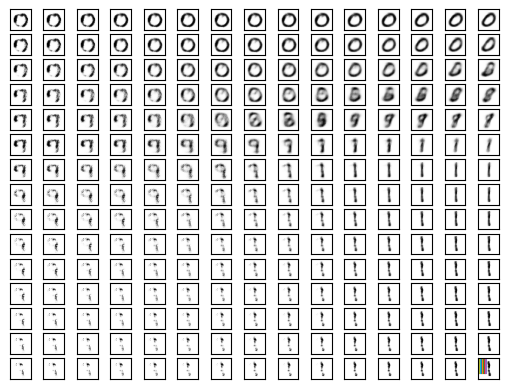

In [11]:
# Plot one of those cool diagrams


rows = 15
cols = 15

xlist = np.linspace(-10, 10, rows)
ylist = np.linspace(-10, 20, cols)

fig, axes = plt.subplots(rows, cols)

xpts, ypts = np.meshgrid(xlist, ylist)

plt.plot(xpts, ypts)


with torch.no_grad():
    for i, row in enumerate(xpts):
        for j, item in enumerate(xpts):
            new_img = mnist_autoencoder.decoder(torch.tensor([xpts[i][j], ypts[i][j]], dtype=torch.float))
            new_img = new_img.reshape((28, 28))
            im = axes[i][j].imshow(new_img.numpy(), cmap = 'Greys')
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])


# Problem 3

a) Train a vanilla GAN, WGAN and variational autoencoder on MNIST data. You can use the examples provided in class. Generate samples from each and train a binary classifier on each vs the reference data. What AUC scores do you get?

b) Train a log posterior metric on all three models. Which performs best?

c) Train a supervised classifier on MNIST and use this to diagnose mode collapse in the three generative models. How do they fare?

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        layer_one_size = 512
        layer_two_size = 256

        self.model = nn.Sequential(
            nn.Linear(input_dim, layer_one_size),
            nn.ReLU(),
            nn.Linear(layer_one_size, layer_two_size),
            nn.ReLU(),
            nn.Linear(layer_two_size, 1), #bring it to just one output
        )

    def forward(self, input):
        return self.model(input)

    def loss(self, input, output):
        return F.binary_cross_entropy(input, output)

class Generator(nn.Module):
    def __init__(self, latent_dim_size, input_dim):
        super(Generator, self).__init__()


        layer_one_size = 64
        layer_two_size = 128
        layer_three_size = 256

        self.model = nn.Sequential(
            nn.Linear(latent_dim_size, layer_one_size),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(layer_one_size),
            nn.Dropout(0.3),
            nn.Linear(layer_one_size, layer_two_size),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(layer_two_size),
            nn.Dropout(0.3),
            nn.Linear(layer_two_size, layer_three_size),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(layer_three_size),
            nn.Dropout(0.3),nn.Linear(layer_three_size, input_dim),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()  # a good idea since the MNIST data set is bound [0,1]
        )

        self.latent_dim_size = latent_dim_size

    def forward(self, input):
        return self.model(input)

    def loss(self, input, output):
        return F.binary_cross_entropy(input, output)


In [13]:
# we need to define the losses

def train_gan(discriminator: Discriminator, generator: Generator, discriminator_optimizer, generator_optimizer, dataset, epochs):
    # first generate set of data

    batch_size = 100

    dataloader = DataLoader(dataset=Subset(dataset, np.random.choice(len(dataset), 10000)), batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        for i, real_data in enumerate(dataloader):
            # generate elements

            latent_space_sample = torch.randn((batch_size, generator.latent_dim_size)).to(device)
            generated_data = generator(latent_space_sample).to(device)

            data_in = real_data[0].to(device)
            real_labels = torch.ones((batch_size)).to(device)
            fake_labels = torch.zeros((batch_size)).to(device)


            # feed to discriminator
            discriminator.train()
            discriminator_optimizer.zero_grad()
            real_loss = F.binary_cross_entropy_with_logits(discriminator(data_in).to(device), real_labels.unsqueeze(1).to(device))
            fake_loss = F.binary_cross_entropy_with_logits(discriminator(generated_data).to(device), fake_labels.unsqueeze(1).to(device))
            discriminator_loss = real_loss+fake_loss
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # Now, train the generator

            latent_space_sample = torch.randn((batch_size, generator.latent_dim_size)).to(device)

            generator.train()

            generator_optimizer.zero_grad()

            output_discriminator_generated = discriminator(generator(latent_space_sample))
            # test against all ones, see how it does
            generated_loss  = F.binary_cross_entropy_with_logits(output_discriminator_generated, real_labels.unsqueeze(1).to(device))

            generated_loss.backward()
            generator_optimizer.step()

        if epoch%5==0:
            with torch.no_grad():
                new_img = (generator(torch.randn(generator.latent_dim_size).to(device)).reshape((28,28)).cpu())
                plt.imshow(new_img, cmap='Grays')
            print(f'Current Generator Loss: {generated_loss}')
            print(f'Current Discriminator Loss: {discriminator_loss}')
            plt.show()


Current Generator Loss: 5.349472522735596
Current Discriminator Loss: 0.01624348759651184


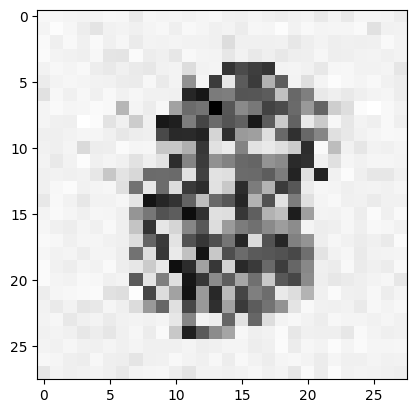

Current Generator Loss: 6.784754276275635
Current Discriminator Loss: 0.005070972256362438


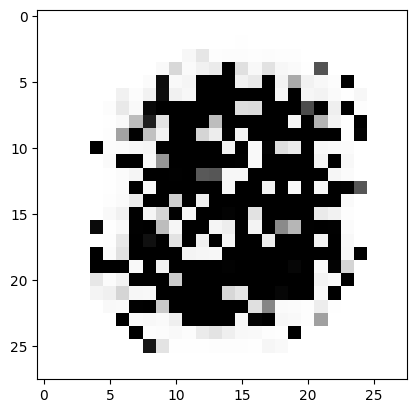

Current Generator Loss: 9.070433616638184
Current Discriminator Loss: 0.00042716582538560033


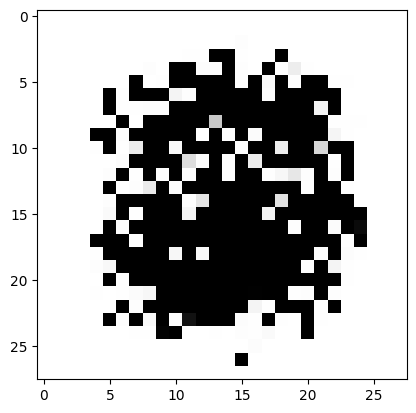

Current Generator Loss: 9.31714153289795
Current Discriminator Loss: 0.00017813518934417516


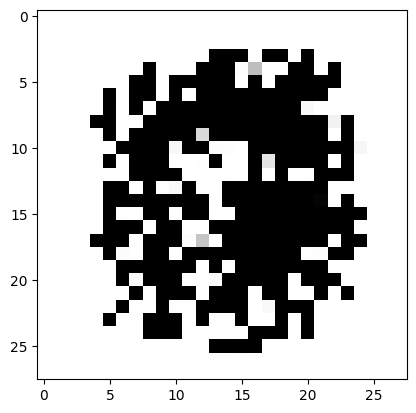

Current Generator Loss: 10.45635986328125
Current Discriminator Loss: 6.341838161461055e-05


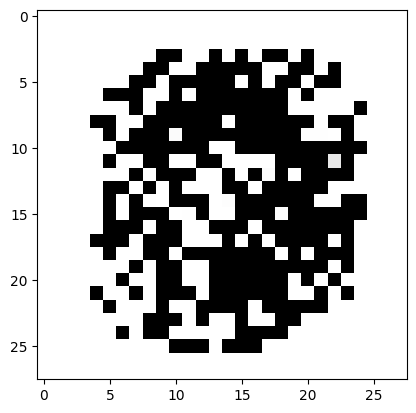

Current Generator Loss: 11.156794548034668
Current Discriminator Loss: 6.638534978264943e-05


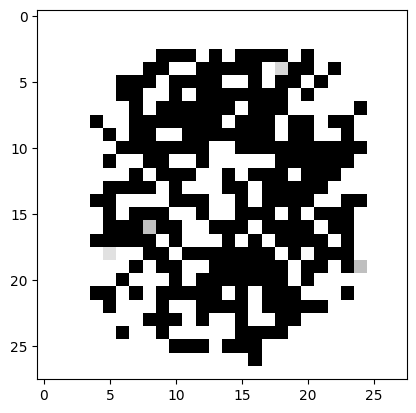

Current Generator Loss: 11.861295700073242
Current Discriminator Loss: 1.7467782527091913e-05


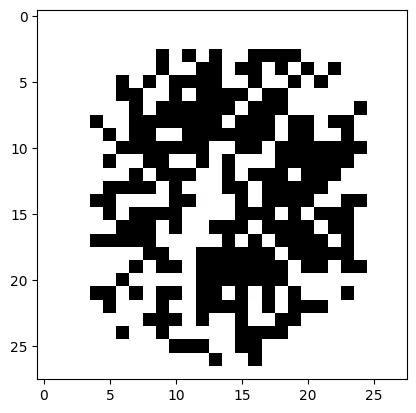

Current Generator Loss: 12.03243350982666
Current Discriminator Loss: 1.840678305597976e-05


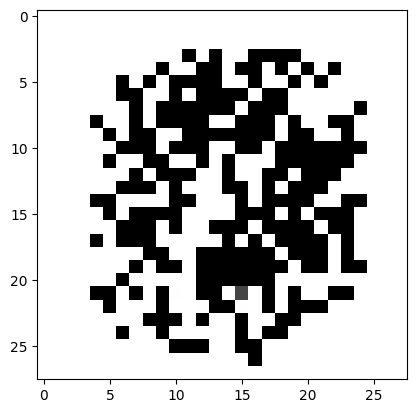

Current Generator Loss: 11.60643482208252
Current Discriminator Loss: 1.5123946468520444e-05


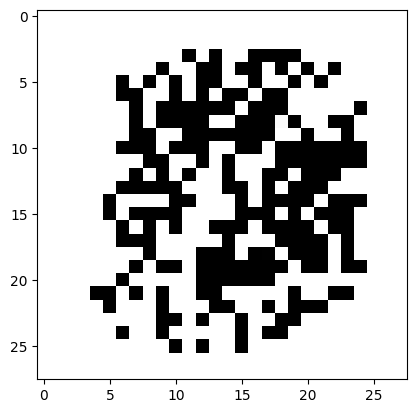

Current Generator Loss: 11.977730751037598
Current Discriminator Loss: 1.656806853134185e-05


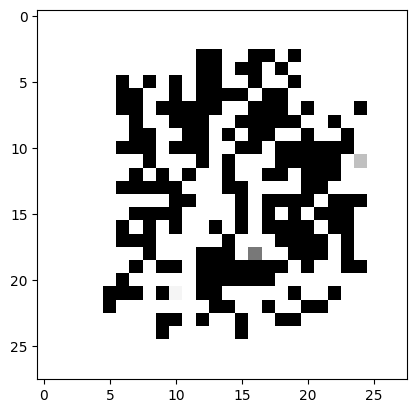

Current Generator Loss: 11.642861366271973
Current Discriminator Loss: 1.0326807569072116e-05


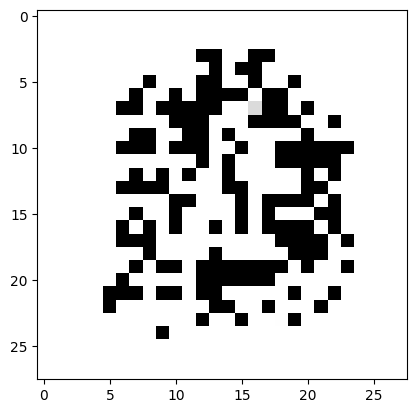

Current Generator Loss: 11.604836463928223
Current Discriminator Loss: 1.0879841283895075e-05


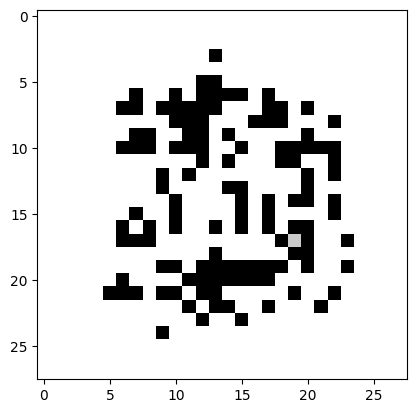

Current Generator Loss: 12.34725570678711
Current Discriminator Loss: 5.771161795564694e-06


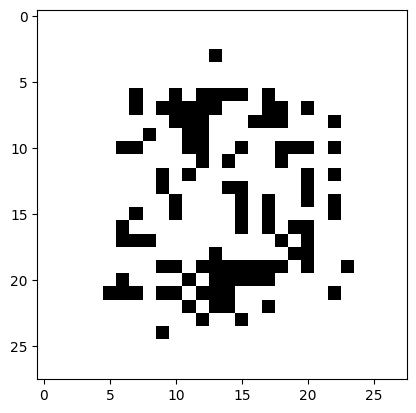

Current Generator Loss: 12.391315460205078
Current Discriminator Loss: 3.982760063081514e-06


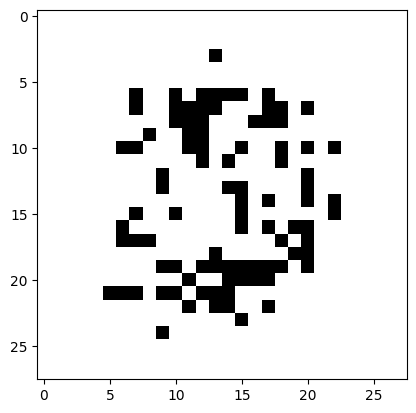

Current Generator Loss: 12.579965591430664
Current Discriminator Loss: 3.8978819247859064e-06


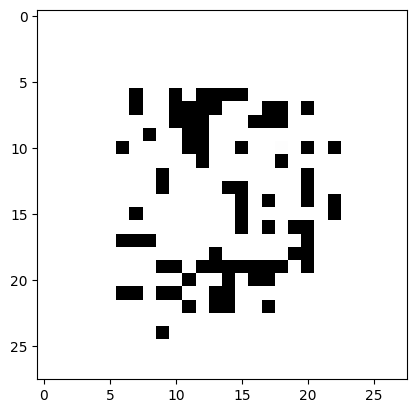

Current Generator Loss: 12.469761848449707
Current Discriminator Loss: 3.920867584383814e-06


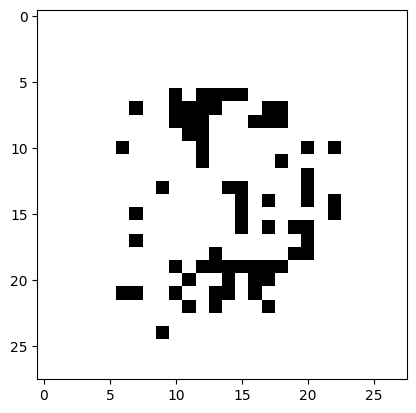

Current Generator Loss: 12.63293170928955
Current Discriminator Loss: 3.2920067951636156e-06


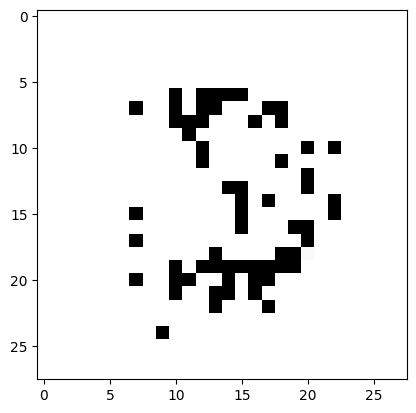

Current Generator Loss: 13.564929008483887
Current Discriminator Loss: 9.997766028391197e-07


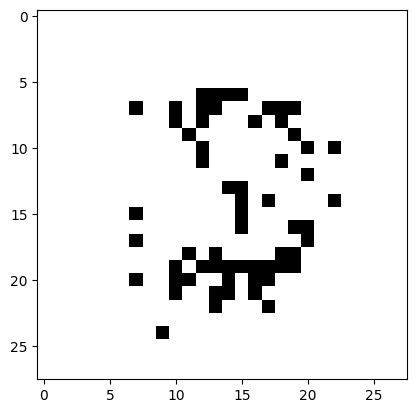

Current Generator Loss: 13.749743461608887
Current Discriminator Loss: 9.59825797508529e-07


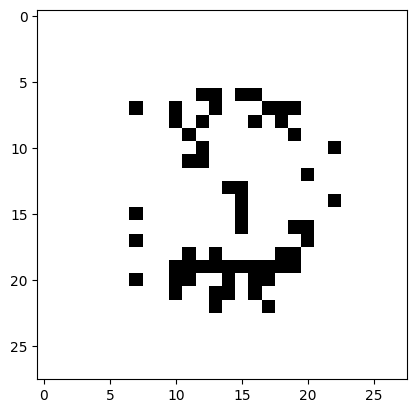

Current Generator Loss: 14.208035469055176
Current Discriminator Loss: 1.6553839259358938e-06


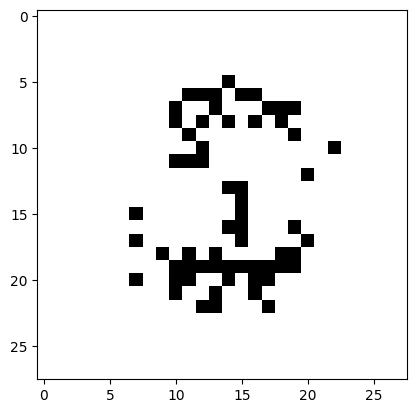

Current Generator Loss: 14.017739295959473
Current Discriminator Loss: 1.1193437785550486e-06


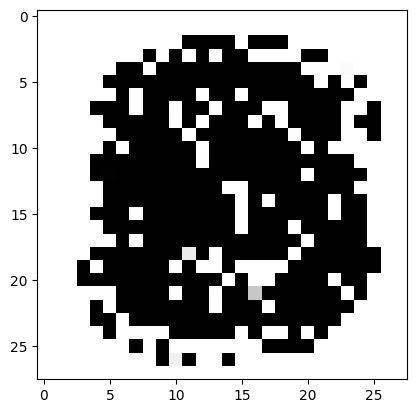

Current Generator Loss: 10.459437370300293
Current Discriminator Loss: 0.002567803720012307


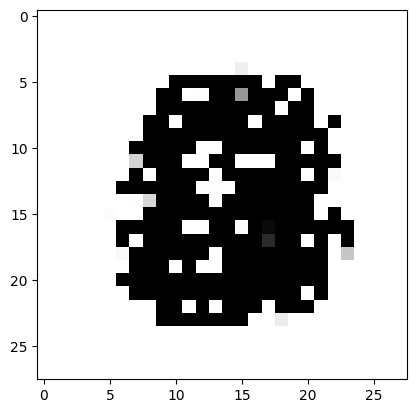

Current Generator Loss: 9.371018409729004
Current Discriminator Loss: 9.705083357403055e-05


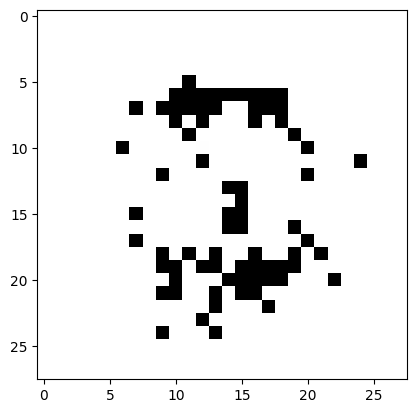

Current Generator Loss: 10.488303184509277
Current Discriminator Loss: 3.196124089299701e-05


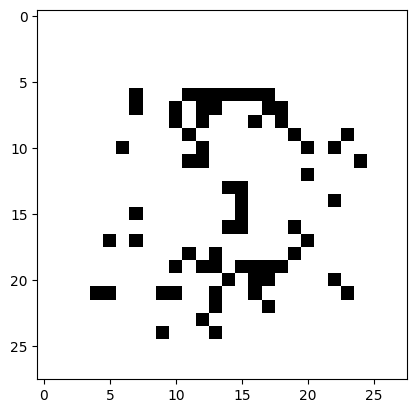

Current Generator Loss: 12.6249361038208
Current Discriminator Loss: 3.2107855076901615e-06


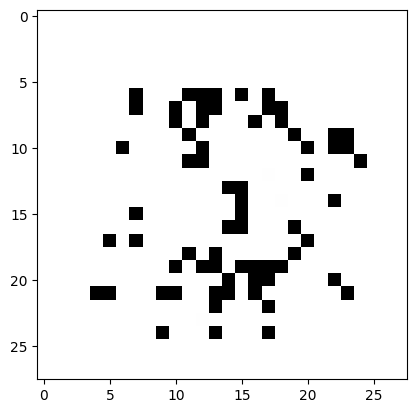

Current Generator Loss: 11.70107364654541
Current Discriminator Loss: 9.296517418988515e-06


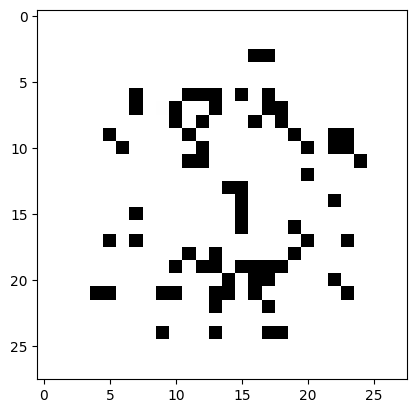

Current Generator Loss: 12.69524097442627
Current Discriminator Loss: 3.032955646631308e-06


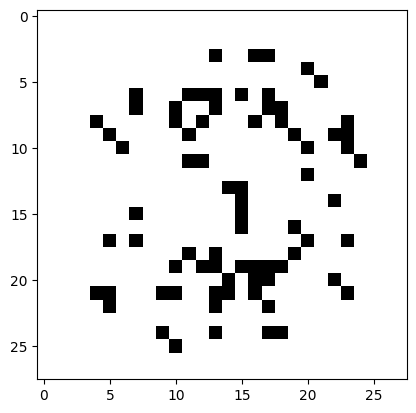

Current Generator Loss: 12.883566856384277
Current Discriminator Loss: 2.6660418370738626e-06


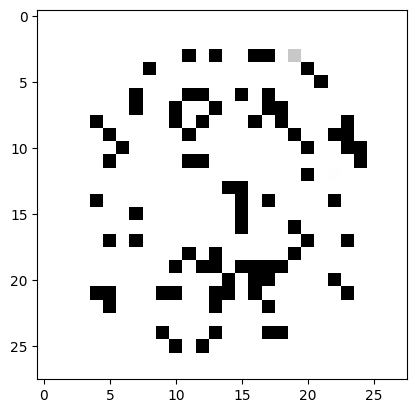

Current Generator Loss: 14.393439292907715
Current Discriminator Loss: 9.827330131884082e-07


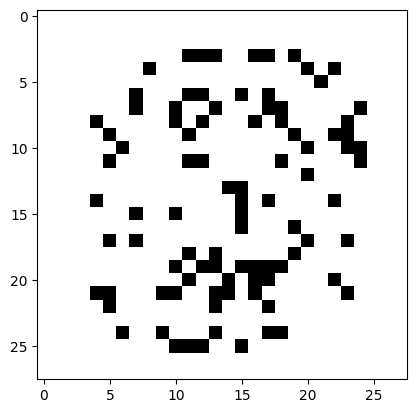

Current Generator Loss: 14.80720329284668
Current Discriminator Loss: 3.019168559603713e-07


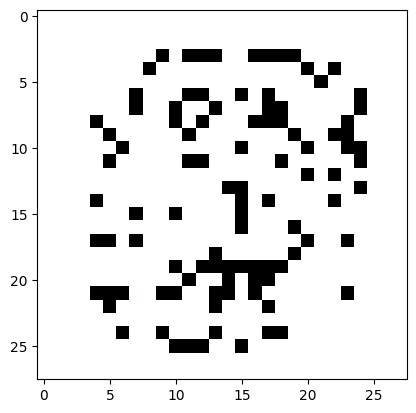

Current Generator Loss: 14.81775188446045
Current Discriminator Loss: 1.0614317943691276e-05


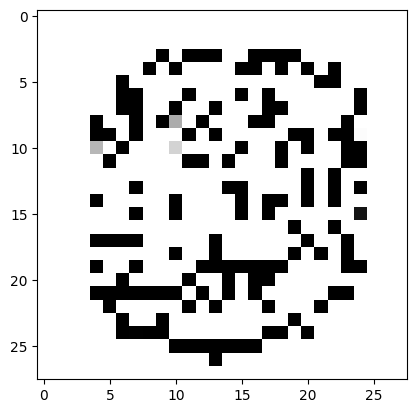

Current Generator Loss: 12.719823837280273
Current Discriminator Loss: 2.066409433609806e-05


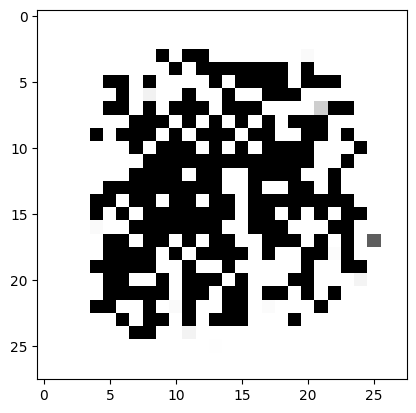

Current Generator Loss: 10.887948989868164
Current Discriminator Loss: 1.971710480574984e-05


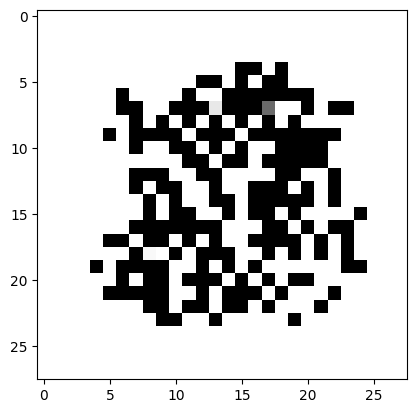

Current Generator Loss: 12.91679573059082
Current Discriminator Loss: 3.231915343349101e-06


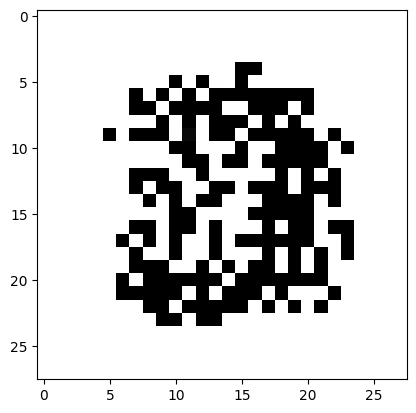

Current Generator Loss: 12.676054000854492
Current Discriminator Loss: 2.874348410841776e-06


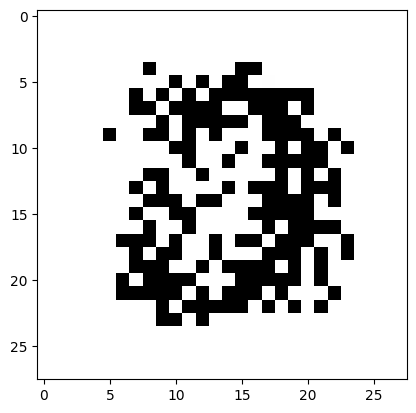

Current Generator Loss: 12.436091423034668
Current Discriminator Loss: 5.344381406757748e-06


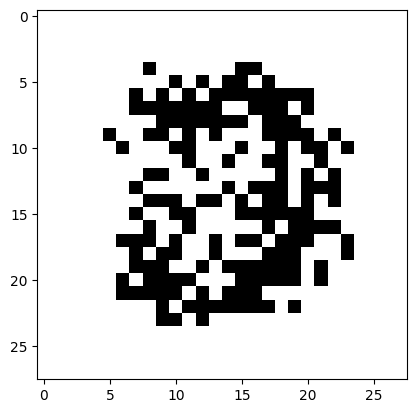

Current Generator Loss: 14.525296211242676
Current Discriminator Loss: 5.24592451256467e-07


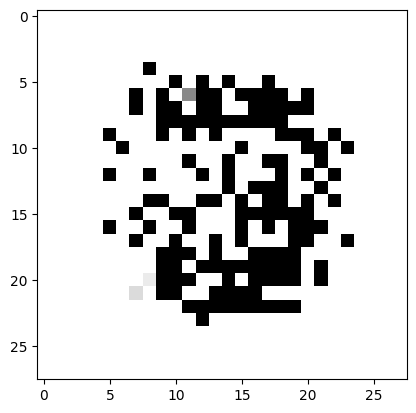

Current Generator Loss: 12.143924713134766
Current Discriminator Loss: 6.273306553339353e-06


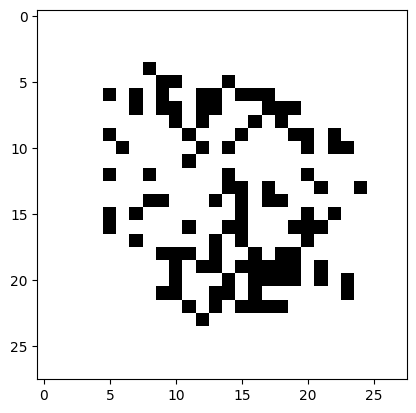

Current Generator Loss: 13.73333740234375
Current Discriminator Loss: 1.351063701804378e-06


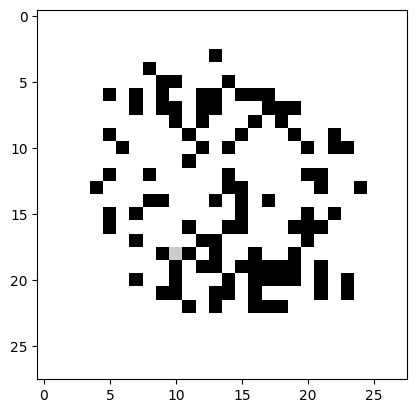

Current Generator Loss: 13.68674087524414
Current Discriminator Loss: 9.747647027325002e-07


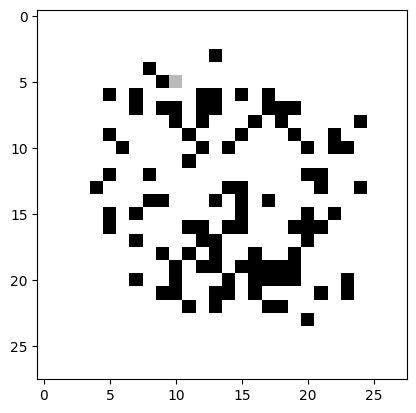

In [15]:
mnist_generator = Generator(32, 28*28)
mnist_discriminator = Discriminator(28*28)



mnist_discriminator.to(device)
mnist_generator.to(device)

mnist_generator_optim = torch.optim.Adam(mnist_generator.parameters(), lr=0.0001)
mnist_discriminator_optim = torch.optim.Adam(mnist_discriminator.parameters(), lr=0.0001)

def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)


init_weights(mnist_discriminator)
init_weights(mnist_generator)


train_gan(mnist_discriminator, mnist_generator, mnist_discriminator_optim, mnist_generator_optim, mnist_data, 200)